The objective of this notebook is to define a set of critetion for two objectieves:
- identify the columns that have different CDF for customers who deafult and customers who do not
- identify the categorical versus cont varialbes (a simple starting point could be setting counting the bins with pfd over a certain threshold)
- look into the number of the NaN values of each of the columns. You may use treat the columns with different proportions of NaN differently. Possibly estimate the NaN values 

## Data Transformations:
Investigate if the data transformations does help the training. The intial investigation on the D columns show that a power transformation such as the sqrt may transform the distribution closer to the Normal

## What do you get out of histogram?
- the probability mass of each bin 
- the range of bins that are above a certain threshold (you may change the mass to the probability and work with that)

In [1]:
import numpy as np
import pandas as pd
from sympy import im 
import torch 
import torch.nn 
import matplotlib.pyplot as plt
import warnings
from pd.nn.model import MLP

from pd.metric import amex_metric
from pd.data.loader import CustomerData, DataLoader
from pd.params import *
from pd.pred import pred_test_npy

In [2]:
train_data = pd.read_parquet(DATADIR+"train_data.parquet")
train_labels = pd.read_csv(DATADIR+"train_labels.csv")
train_labels.set_index("customer_ID", inplace=True)


In [3]:
c1 = train_labels[train_labels.target==1]
c1d = train_data[train_data.customer_ID.isin(c1.index)]
c0d = train_data[~train_data.customer_ID.isin(c1.index)]


<AxesSubplot:ylabel='Frequency'>

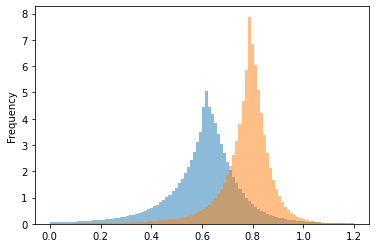

In [61]:
c = "P_3"
train_data[c].plot(kind="hist", bins=100, density=True, alpha=.5, range=[0, 1.2])

train_data[c].apply(np.sqrt).plot(kind="hist", bins=100, density=True, alpha=.5, range=[0, 1.2])

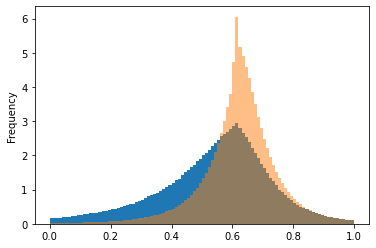

<AxesSubplot:ylabel='Frequency'>

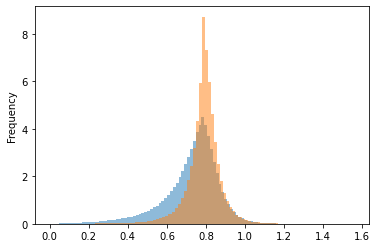

In [62]:

c1d[c].plot(kind="hist", bins=100, density=True, range=[0, 1])
c0d[c].plot(kind="hist", bins=100, alpha=.5, density=True, range=[0, 1])
plt.show()
c1d[c].apply(np.sqrt).plot(kind="hist", bins=100, density=True, alpha=.5, )
c0d[c].apply(np.sqrt).plot(kind="hist", bins=100, alpha=.5, density=True, )

<AxesSubplot:ylabel='Frequency'>

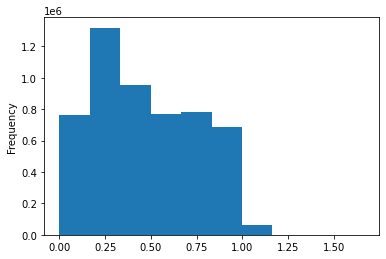

In [11]:
train_data.D_55.apply(np.sqrt).plot(kind="hist", range=[0, 1])

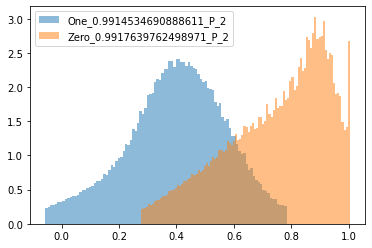

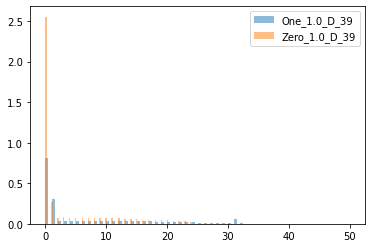

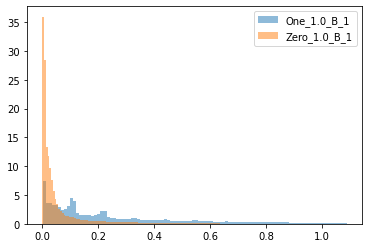

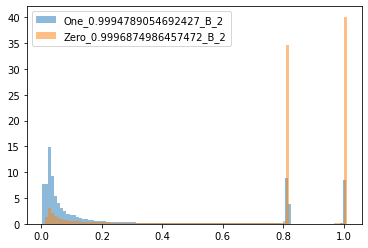

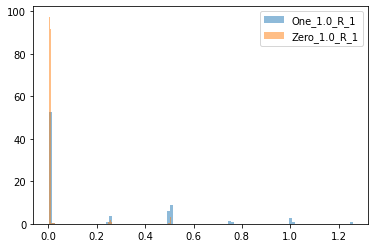

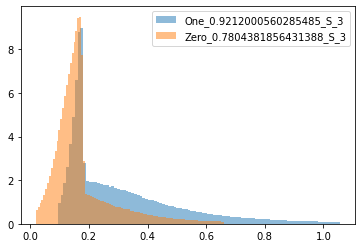

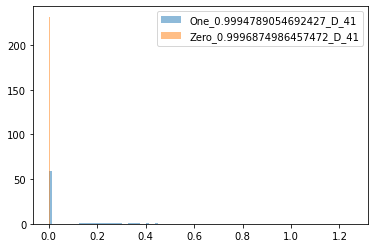

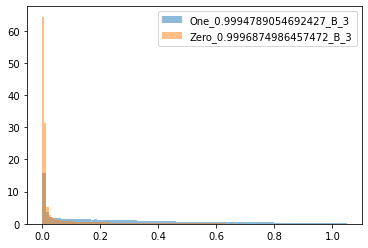

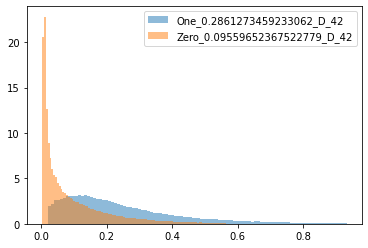

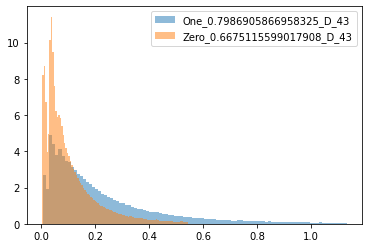

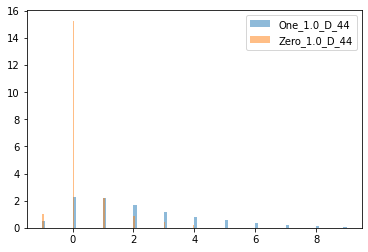

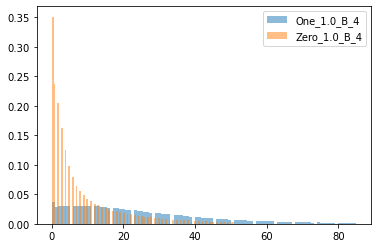

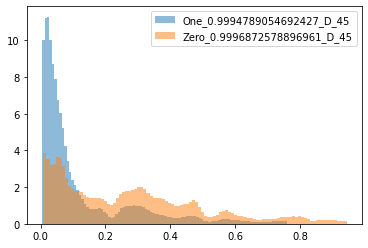

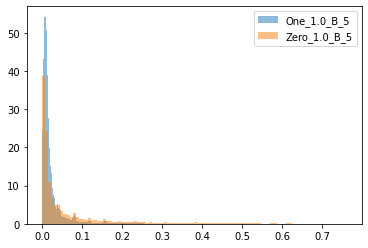

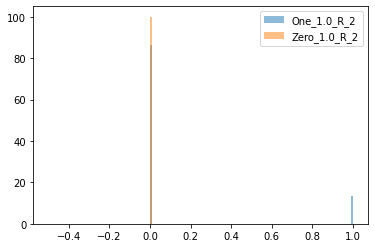

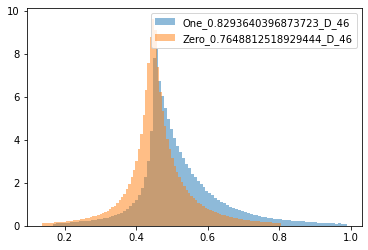

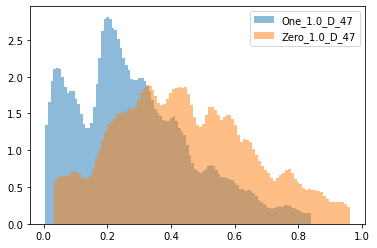

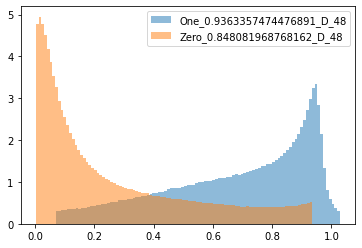

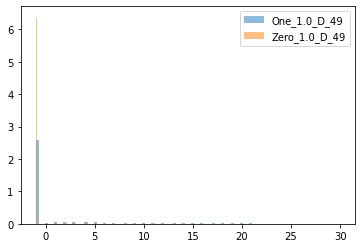

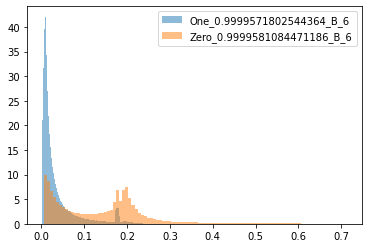

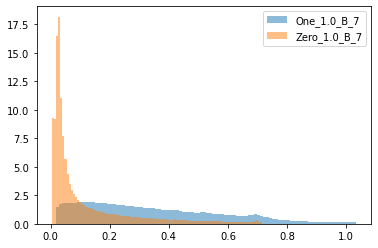

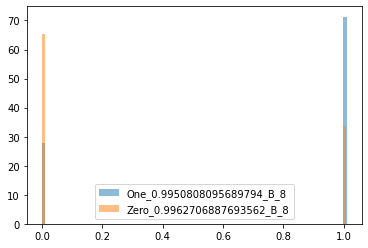

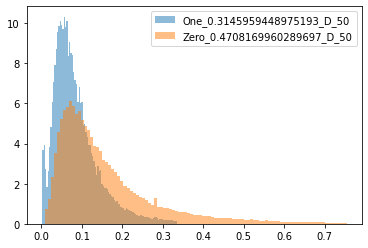

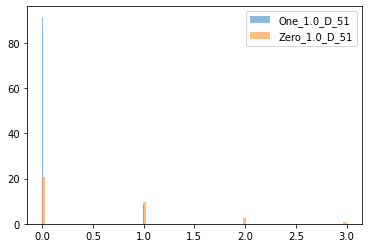

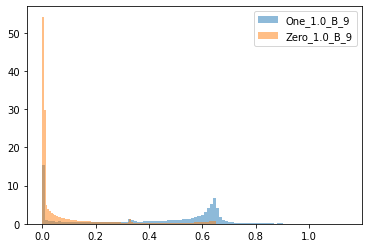

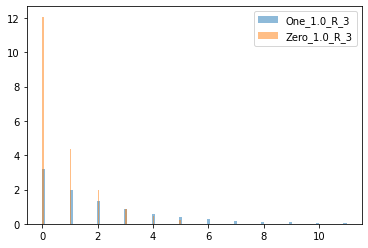

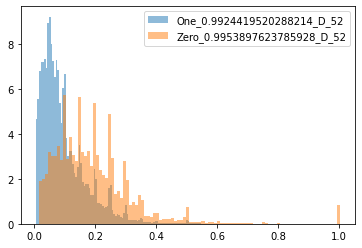

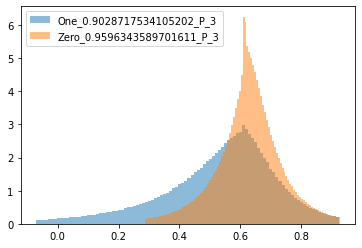

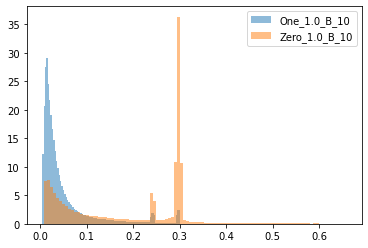

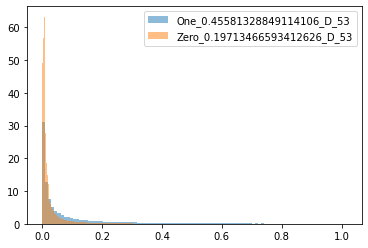

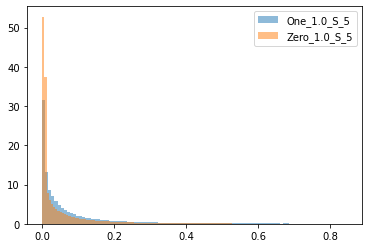

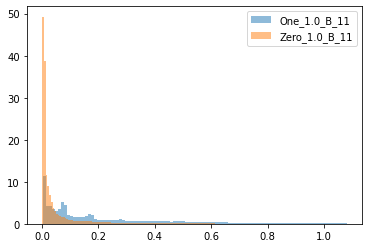

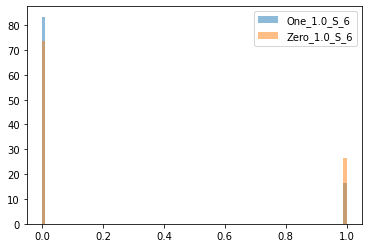

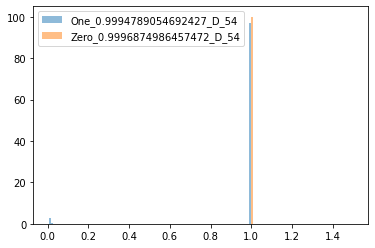

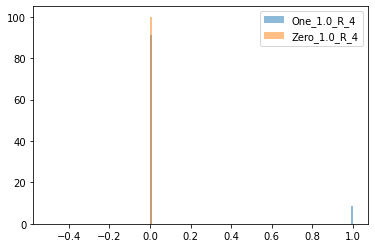

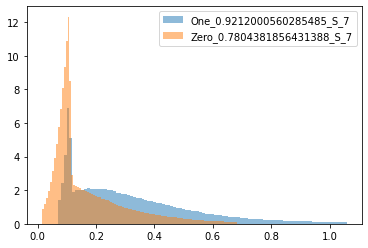

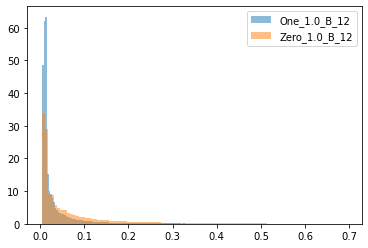

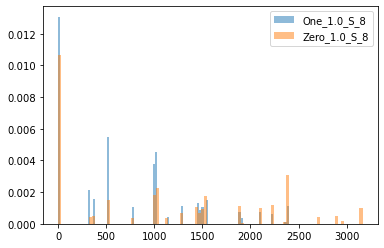

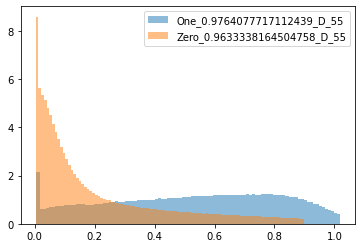

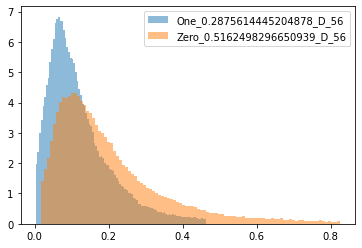

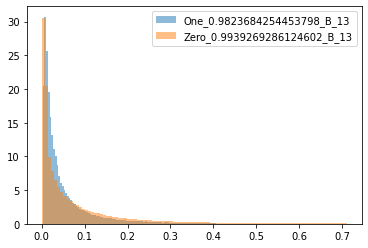

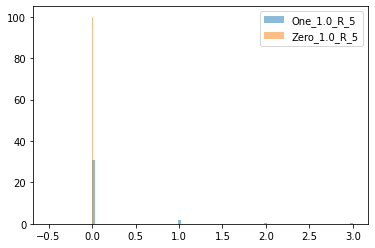

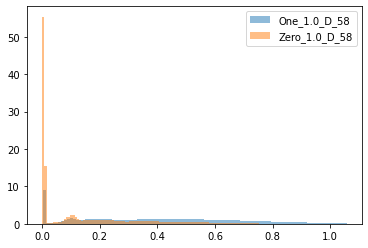

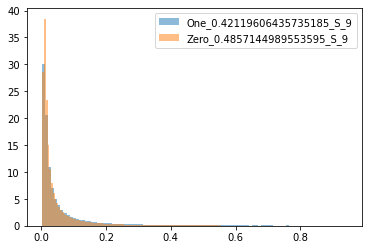

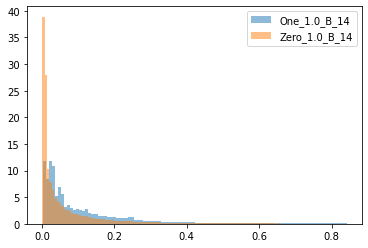

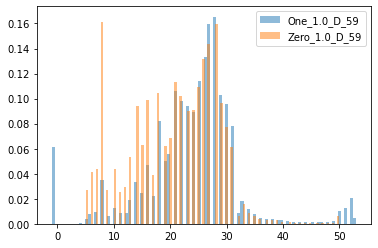

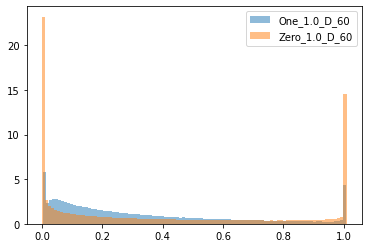

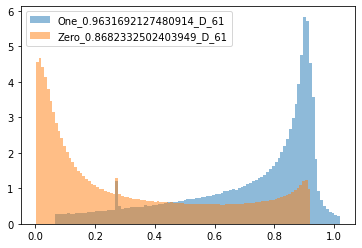

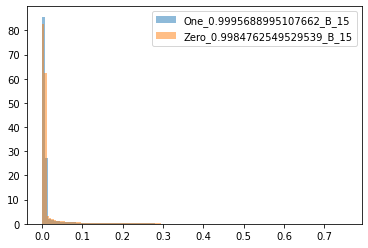

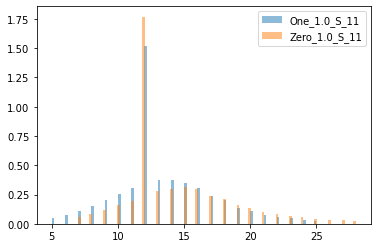

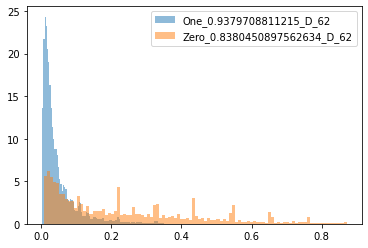

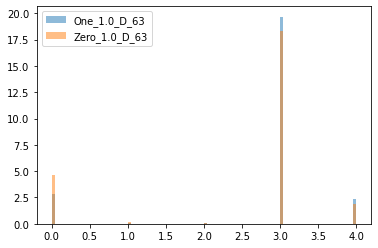

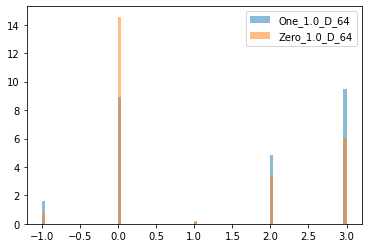

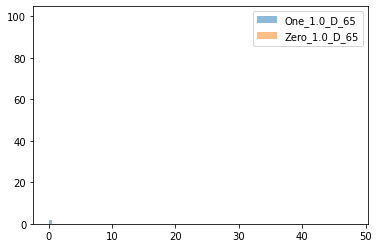

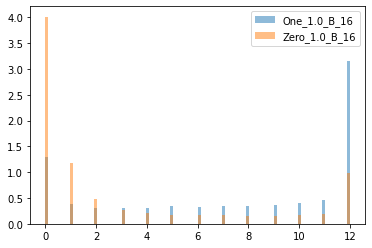

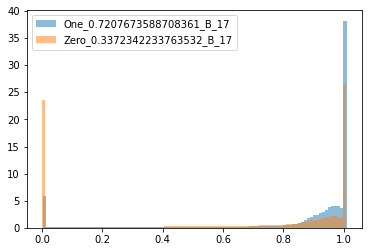

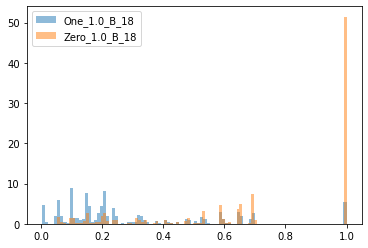

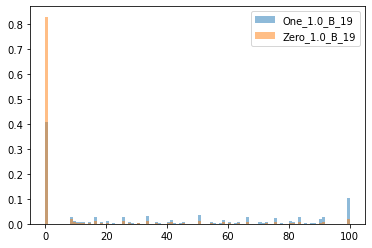

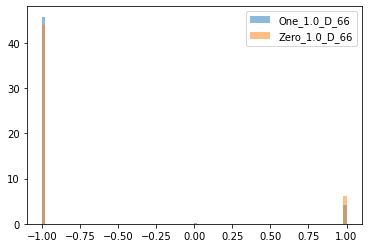

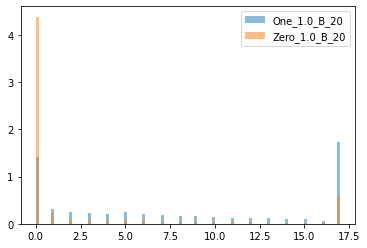

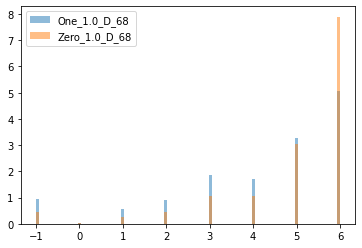

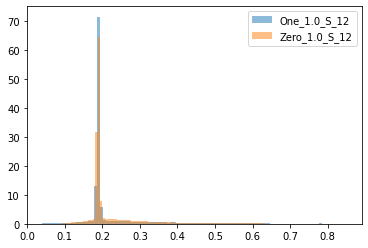

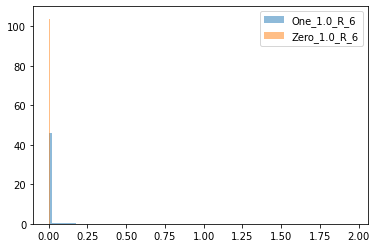

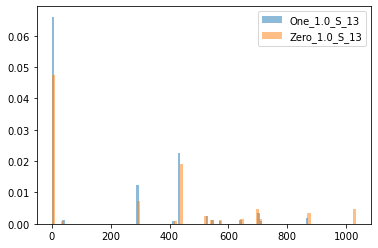

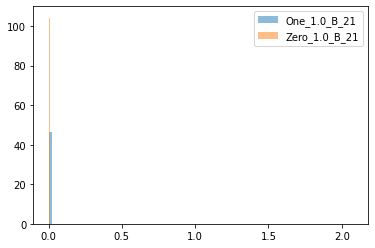

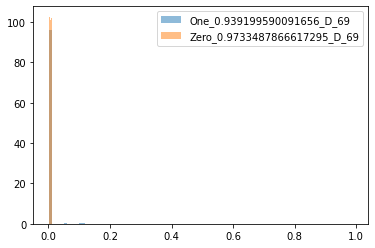

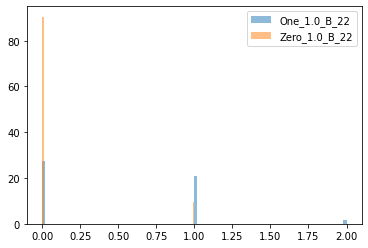

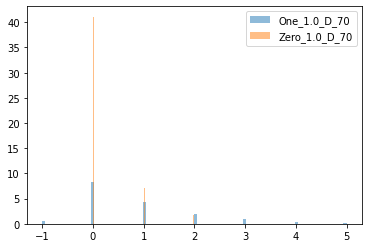

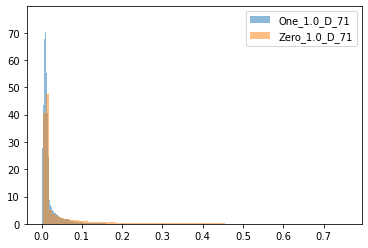

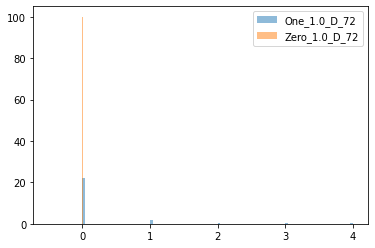

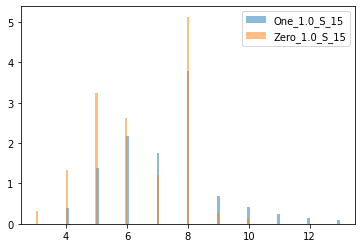

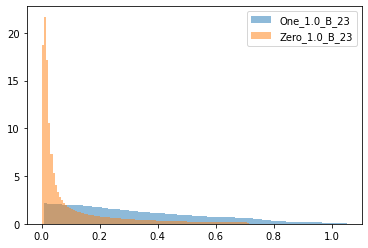

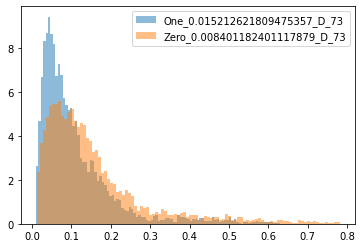

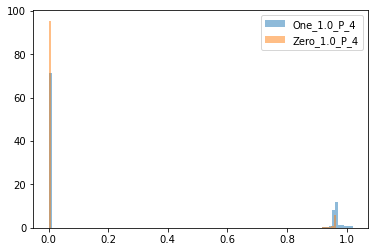

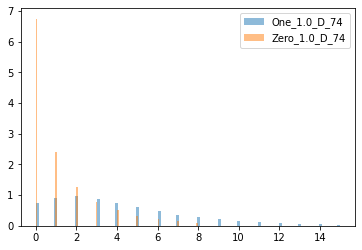

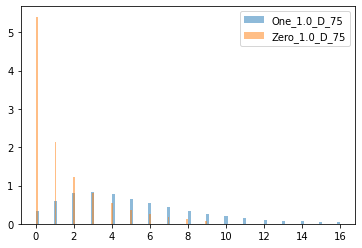

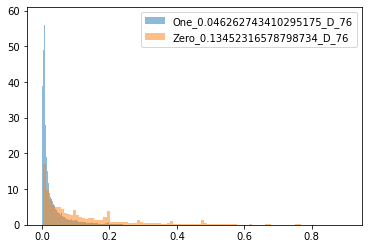

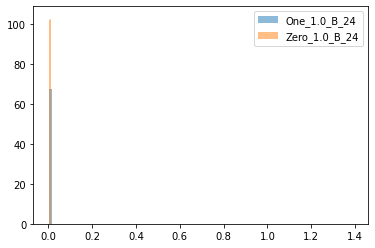

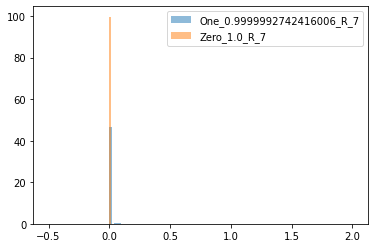

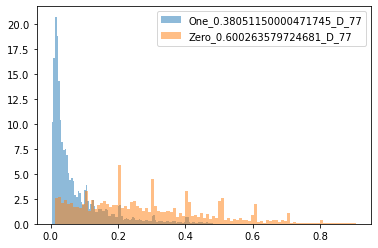

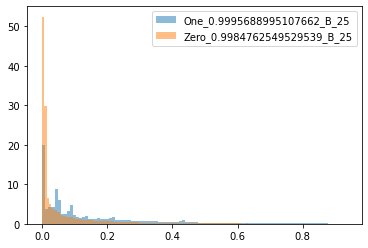

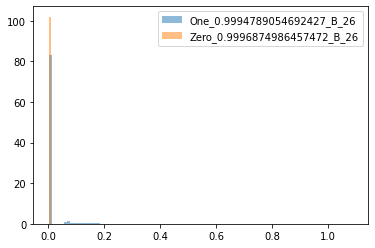

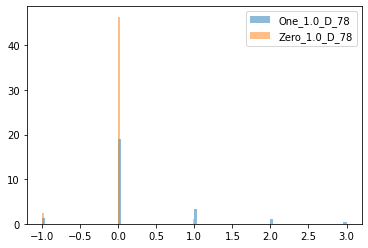

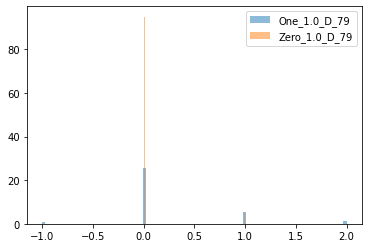

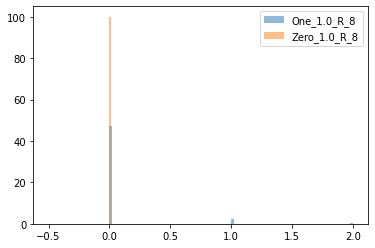

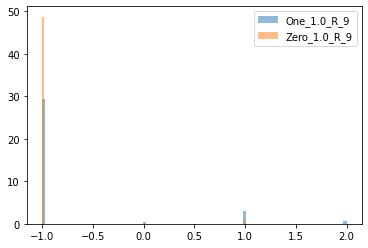

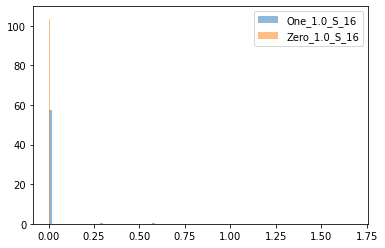

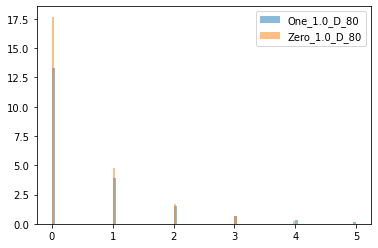

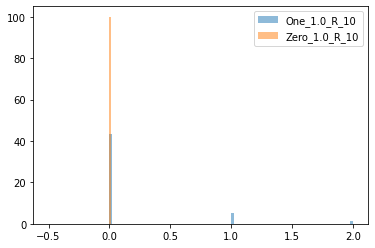

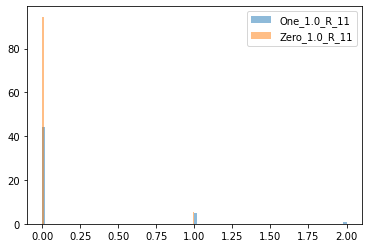

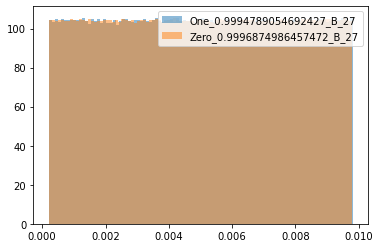

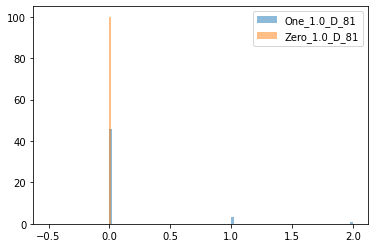

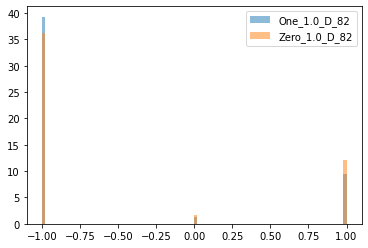

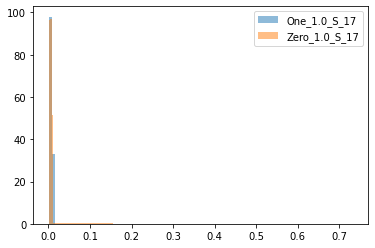

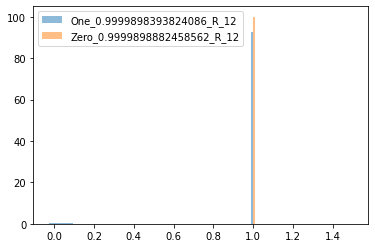

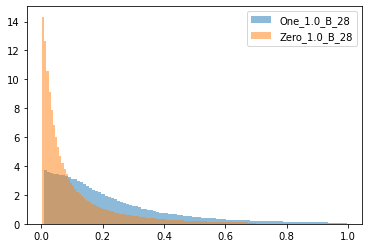

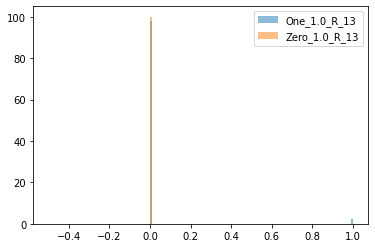

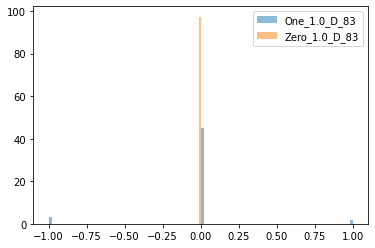

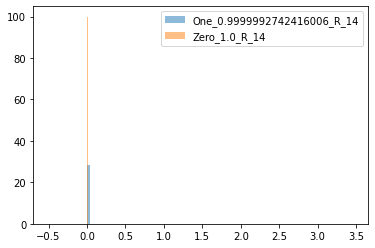

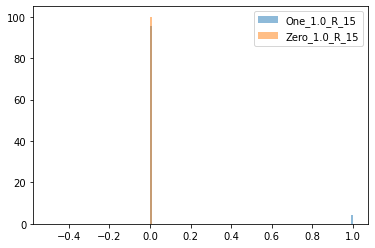

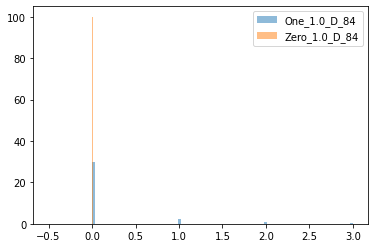

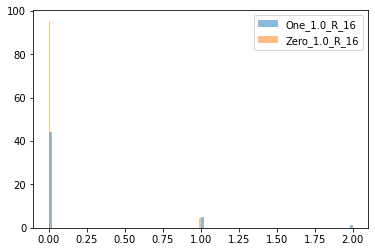

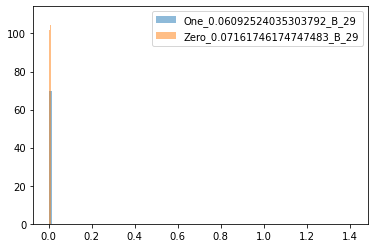

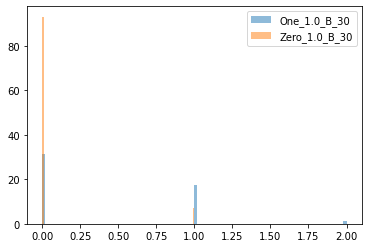

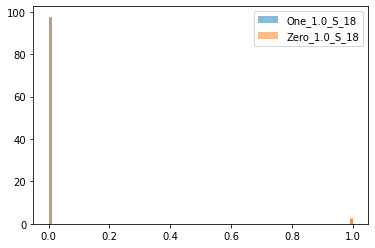

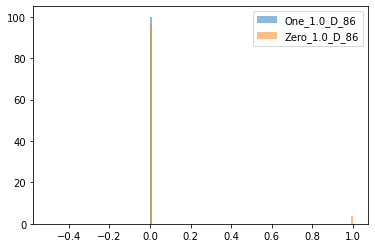

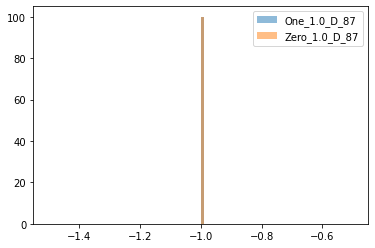

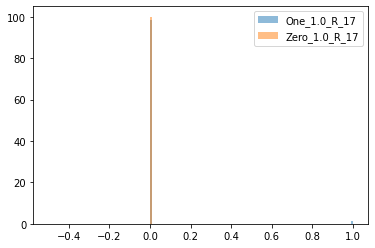

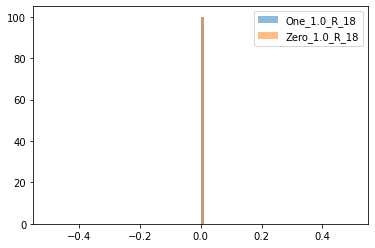

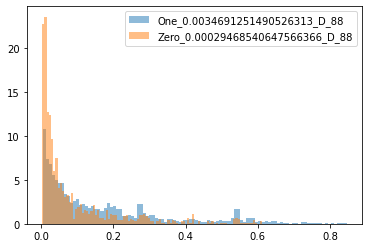

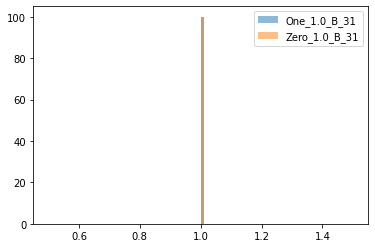

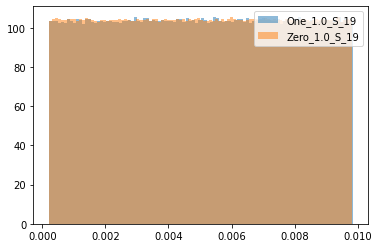

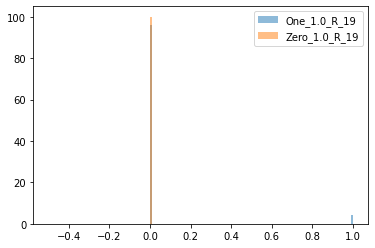

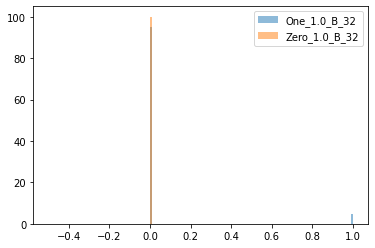

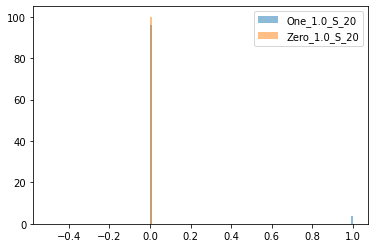

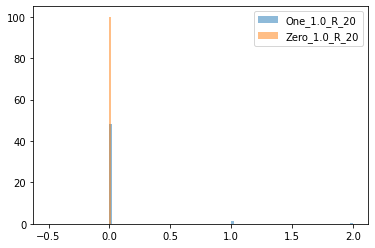

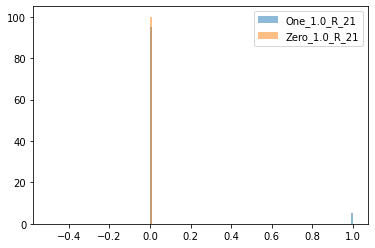

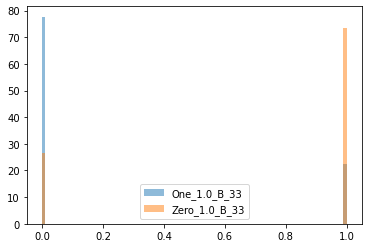

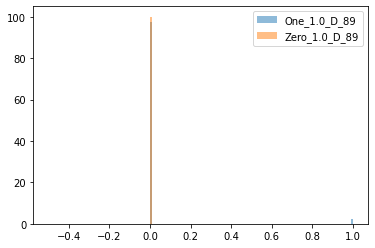

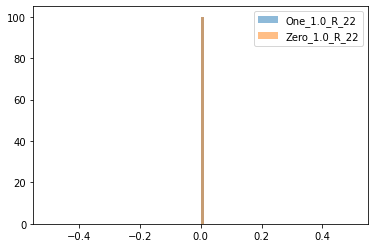

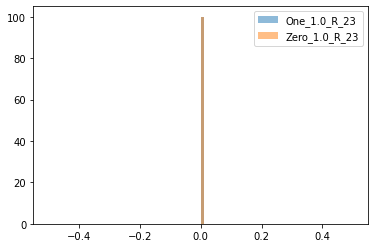

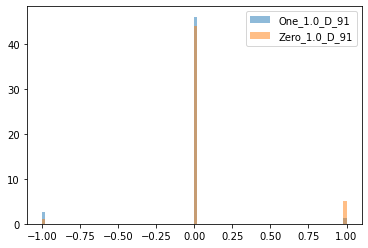

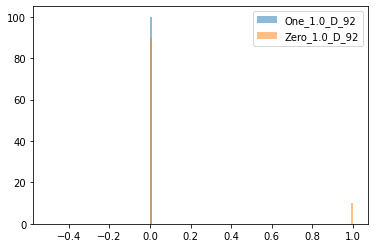

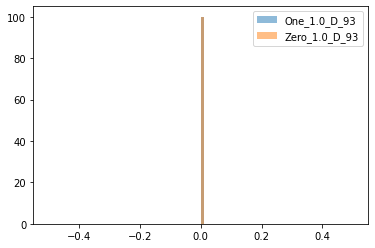

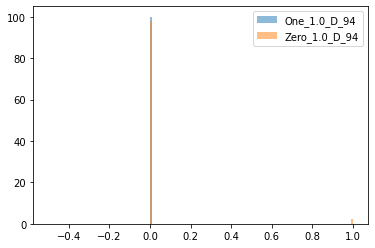

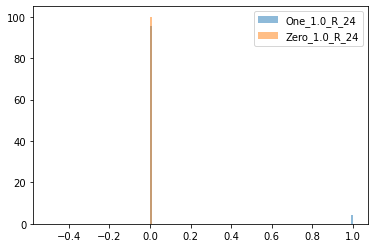

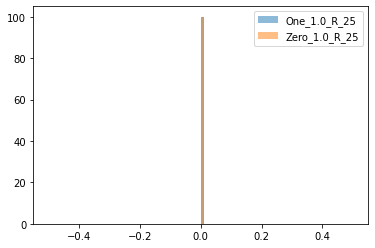

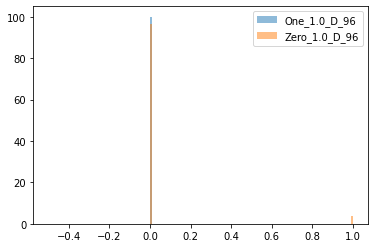

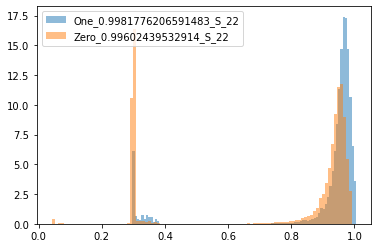

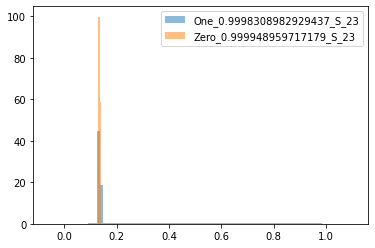

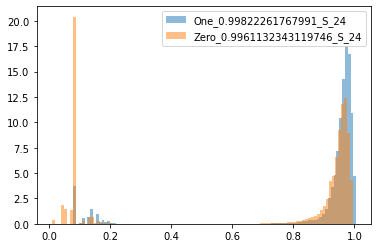

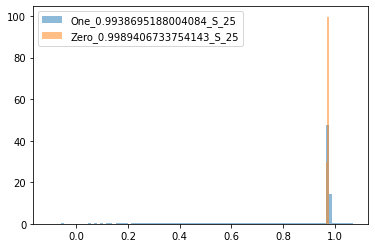

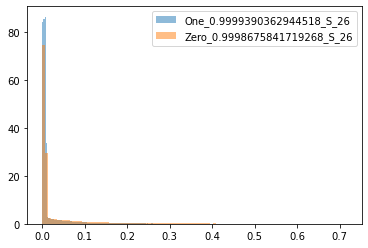

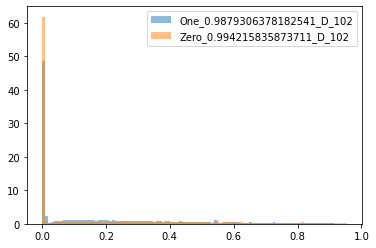

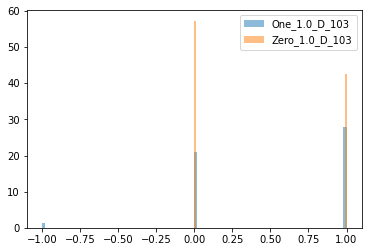

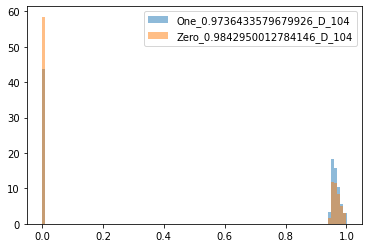

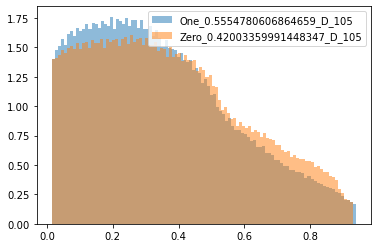

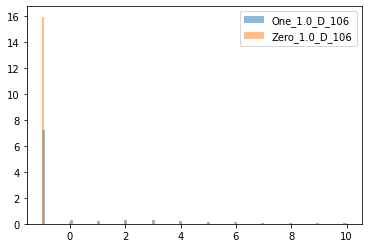

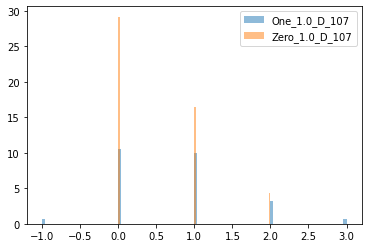

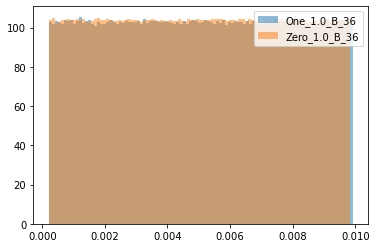

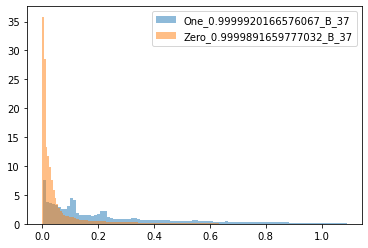

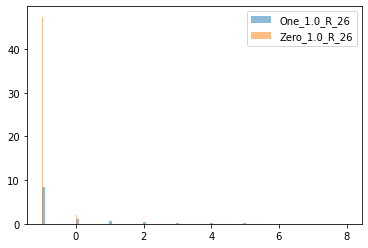

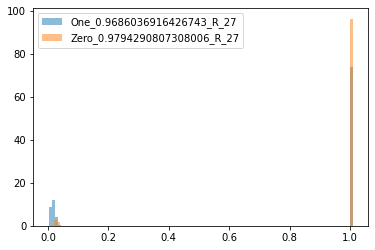

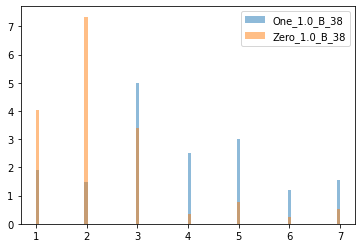

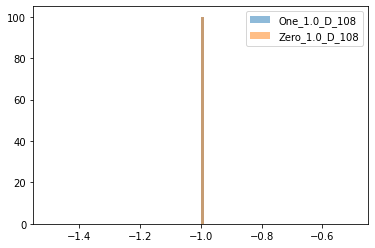

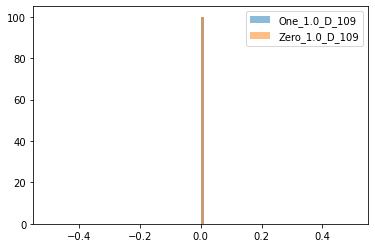

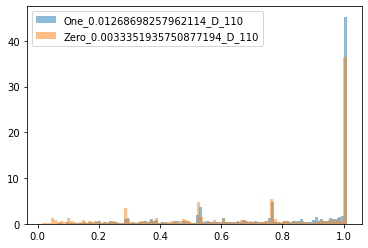

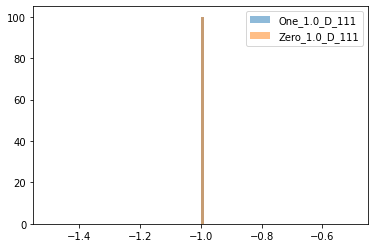

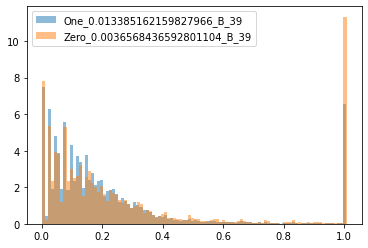

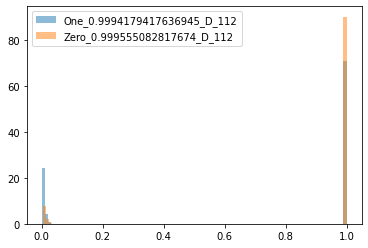

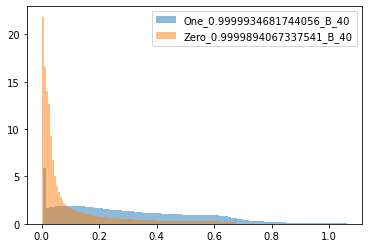

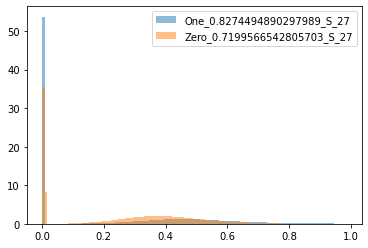

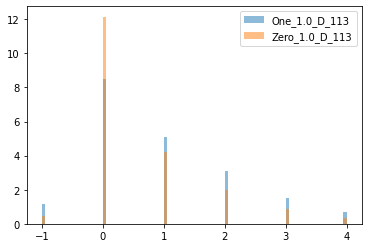

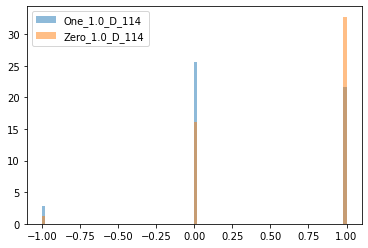

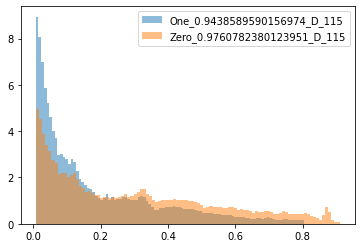

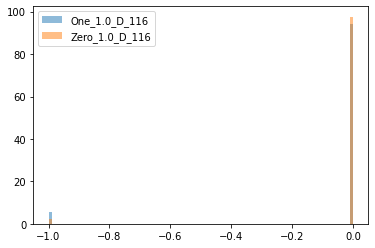

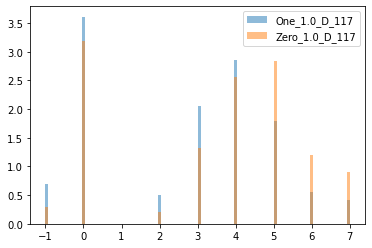

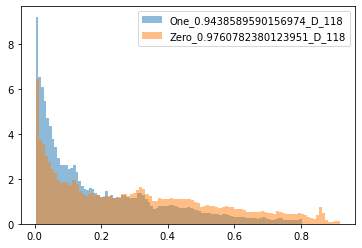

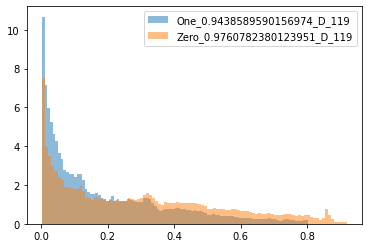

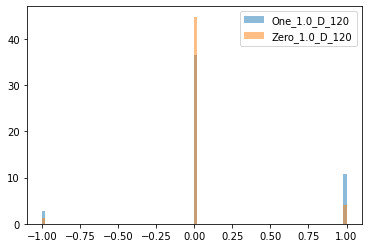

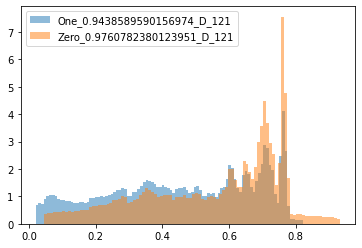

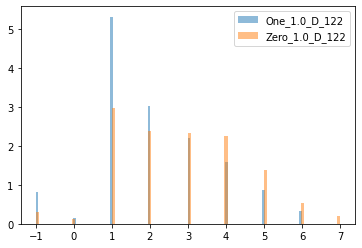

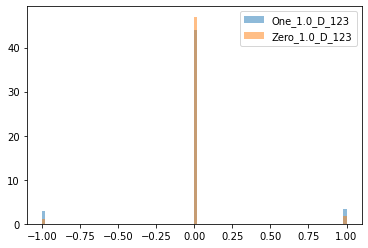

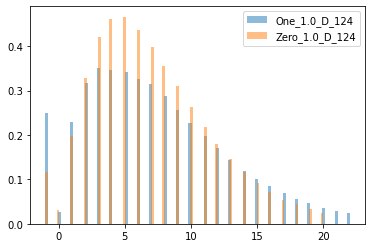

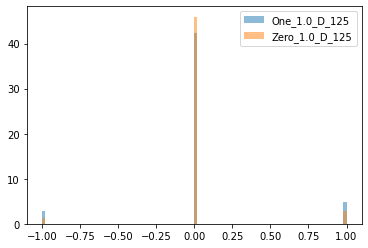

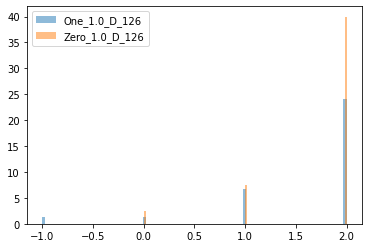

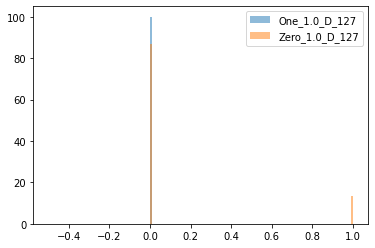

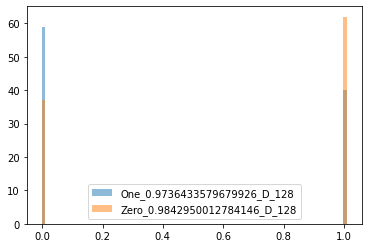

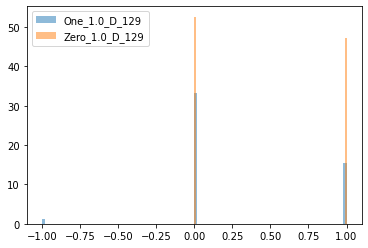

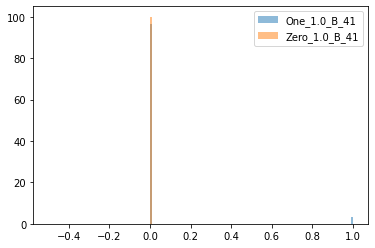

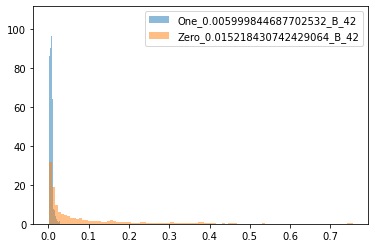

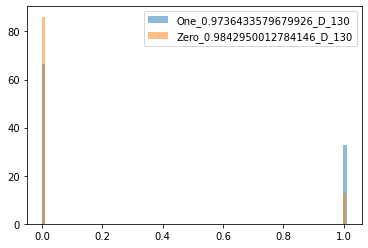

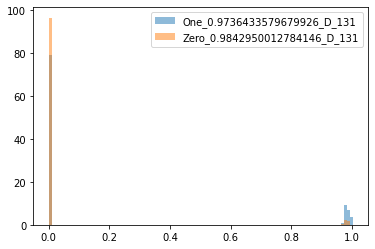

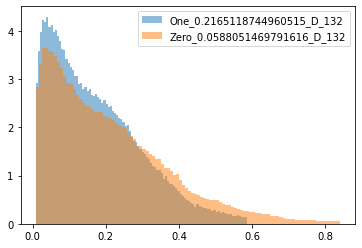

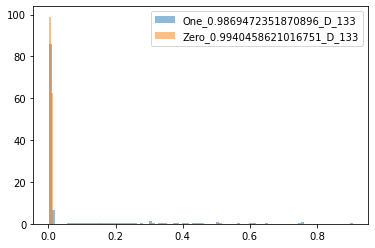

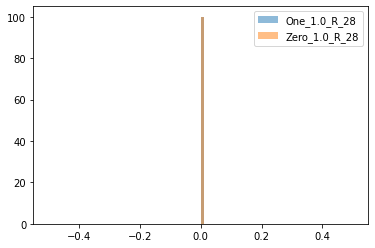

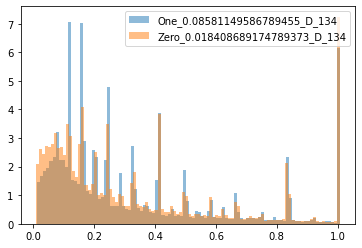

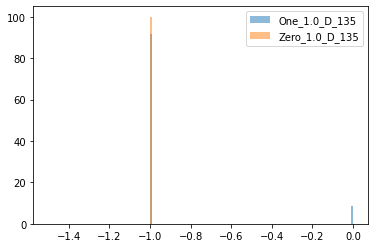

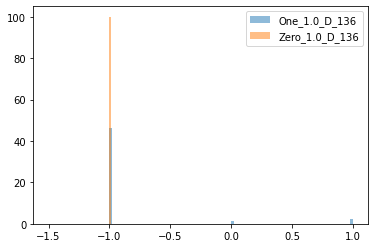

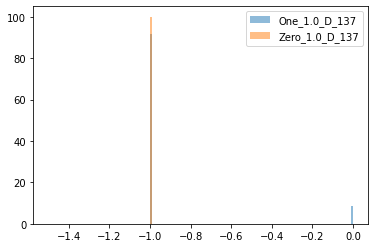

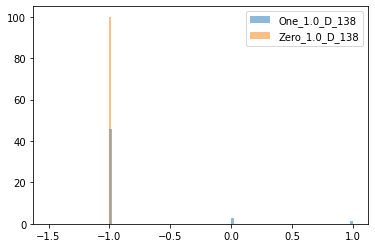

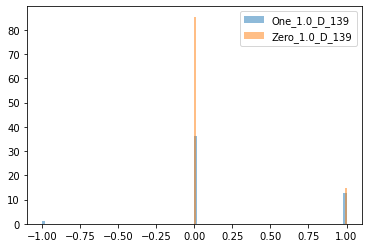

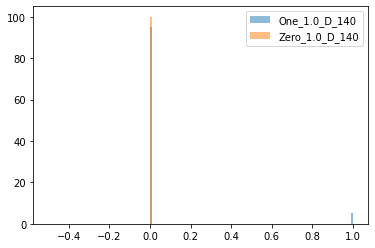

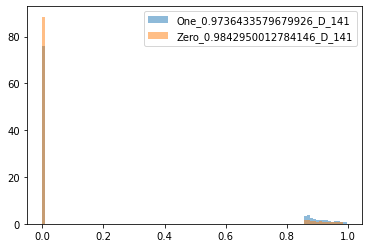

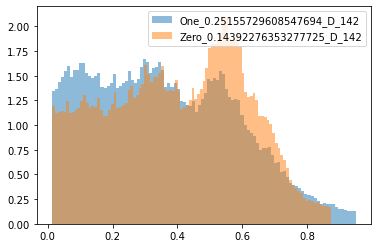

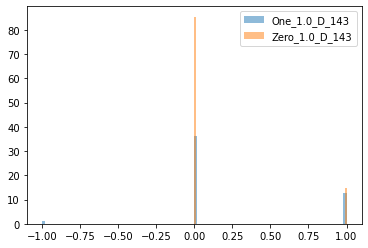

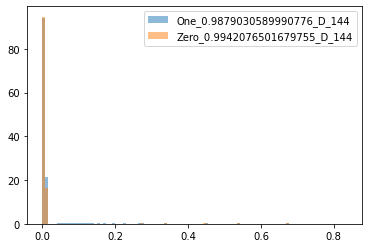

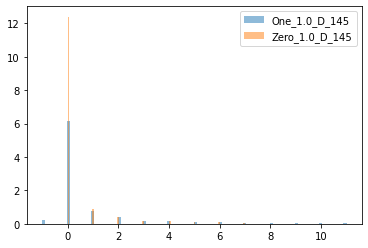

In [4]:
N0 = c0d.shape[0]
N1 = c1d.shape[0]

feat_dist = {}

for c in train_data.columns:
    feat_dist[c] = {}
    if  train_data.dtypes[c] != object:
        d1 = c1d[c].dropna()
        q11 = d1.quantile(.02)
        q12 = d1.quantile(.98)
        hist1 = plt.hist(d1, range=[q11, q12], bins=100, label=f"One_{d1.shape[0]/N1}_{c}", density=True, alpha=0.5)
        feat_dist[c][1] = hist1
        d0 = c0d[c].dropna()
        q01 = d0.quantile(.02)
        q02 = d0.quantile(.98)
        hist0 = plt.hist(d0, range=[q01, q02], bins=100, label=f"Zero_{d0.shape[0]/N0}_{c}", density=True, alpha=0.5)
        feat_dist[c][0] = hist0
        feat_dist[c]["q2"] = np.minimum(q01, q11)
        feat_dist[c]["q98"] = np.maximum(q02, q12)
        plt.legend()
        plt.show()


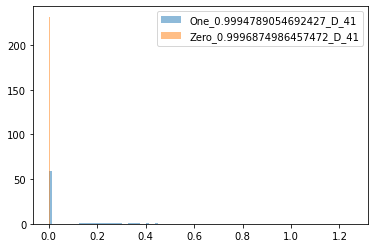

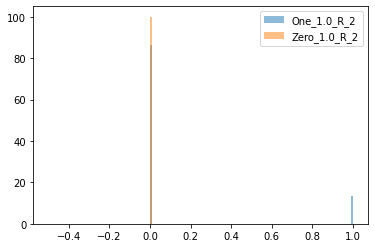

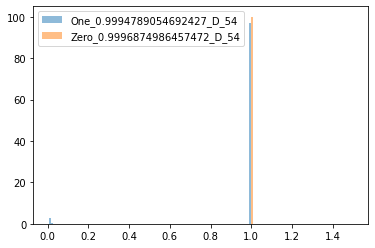

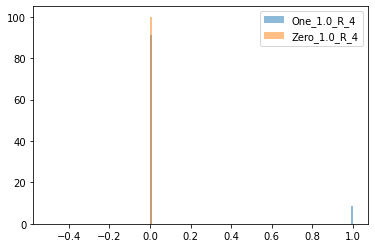

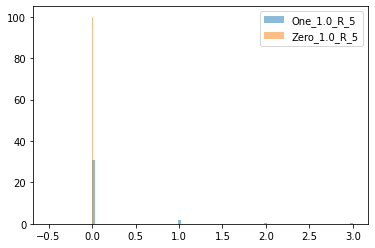

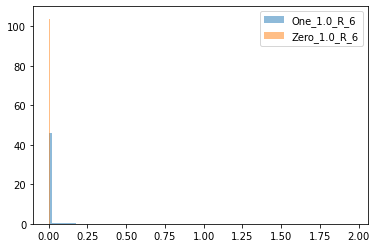

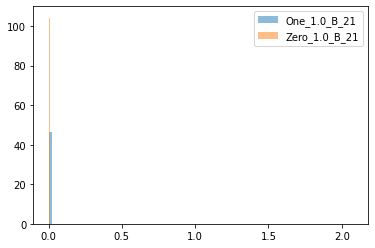

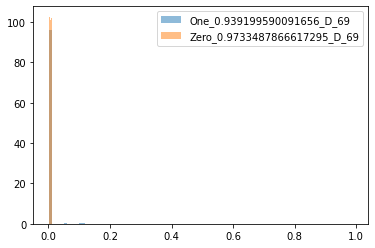

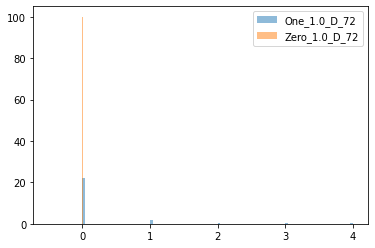

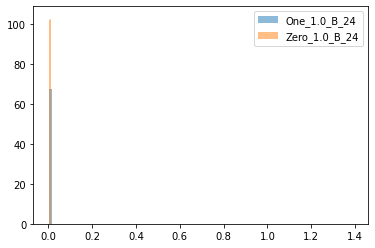

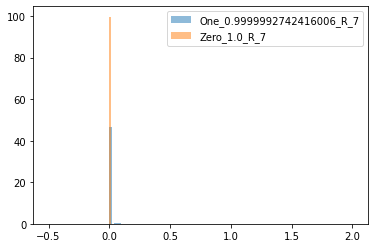

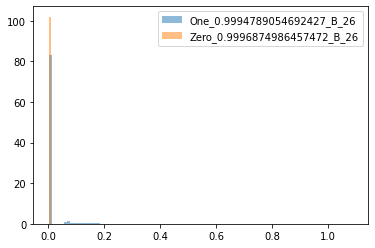

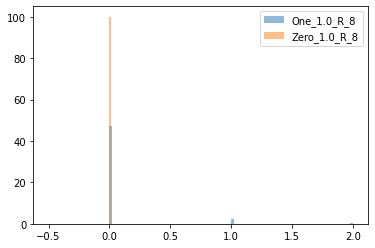

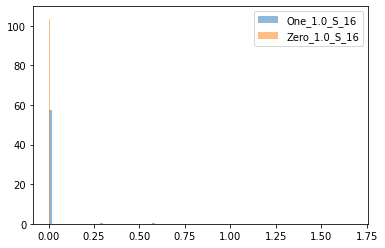

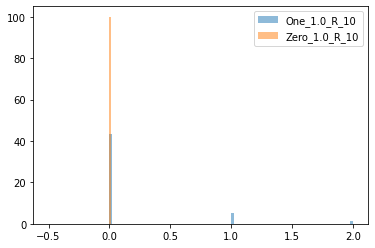

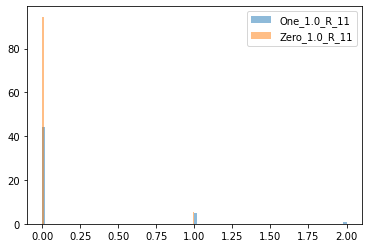

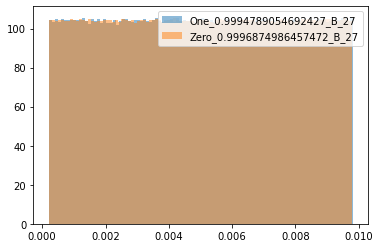

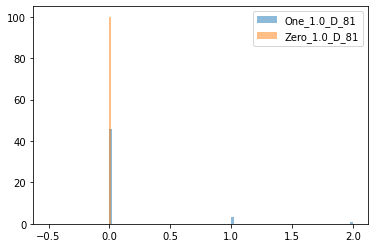

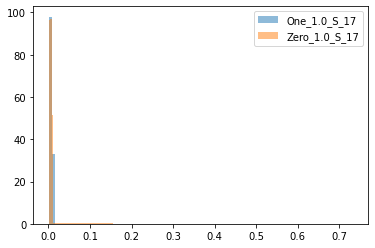

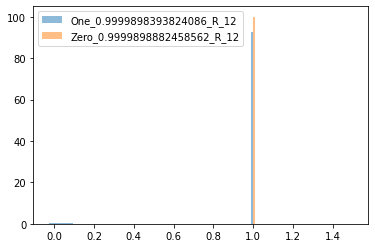

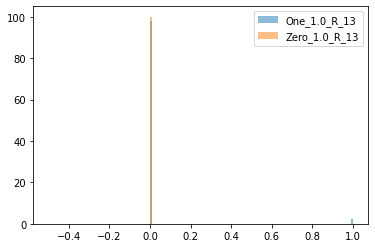

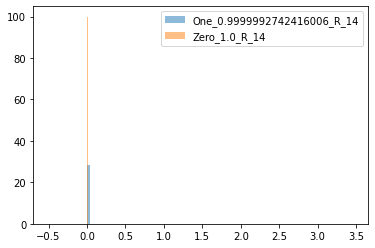

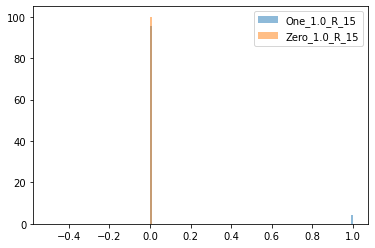

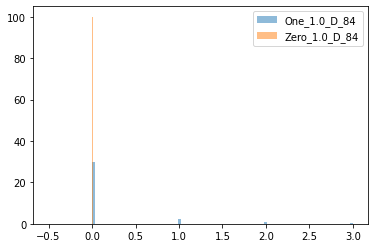

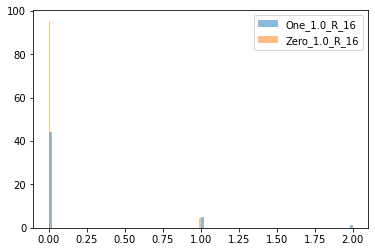

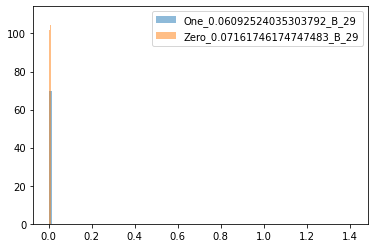

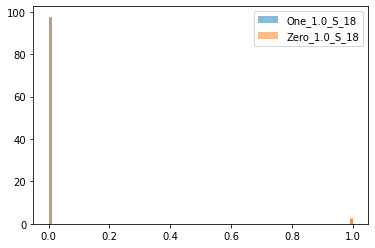

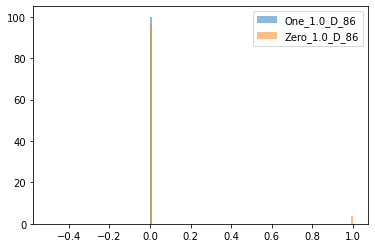

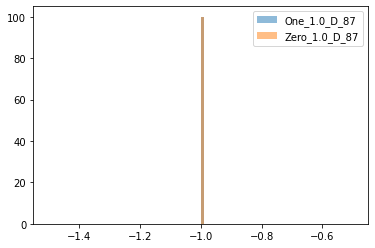

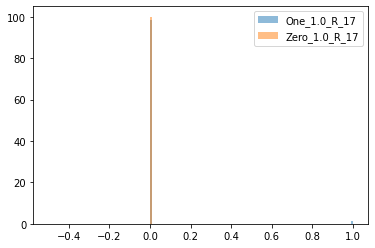

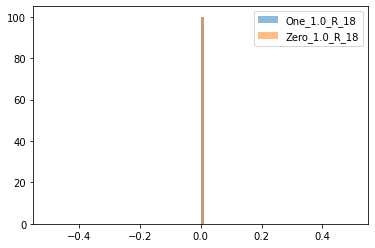

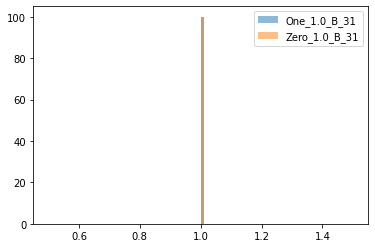

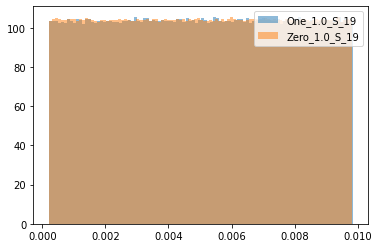

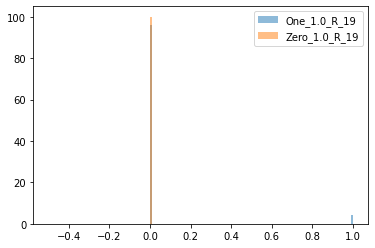

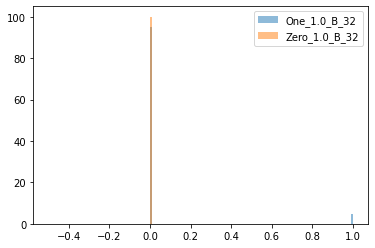

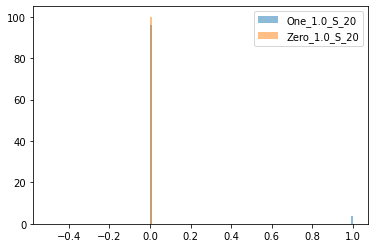

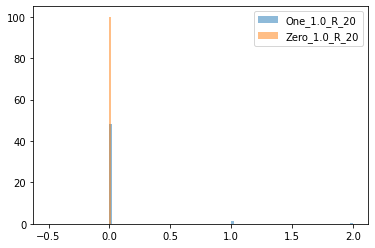

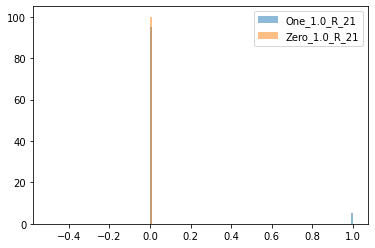

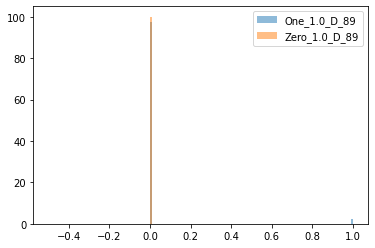

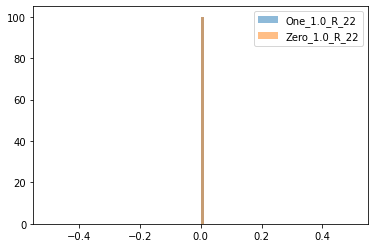

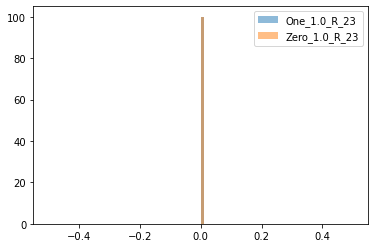

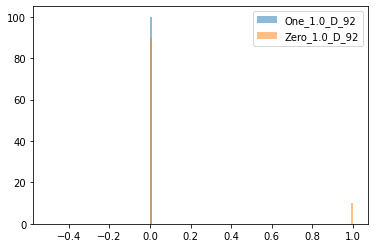

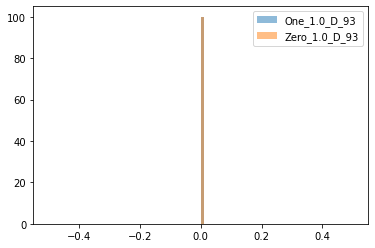

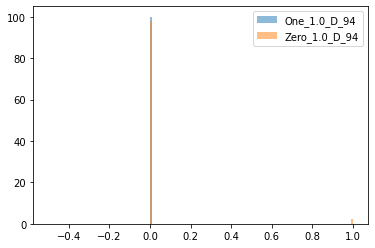

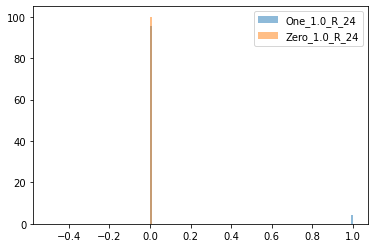

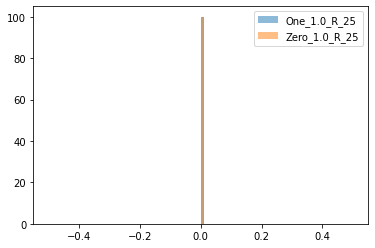

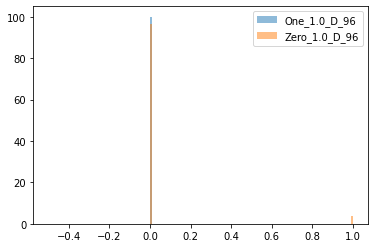

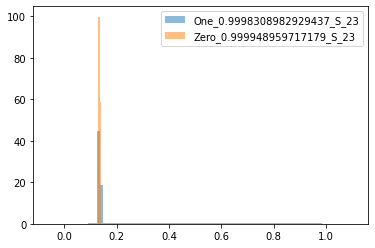

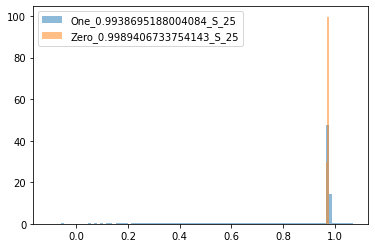

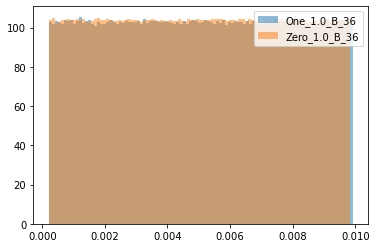

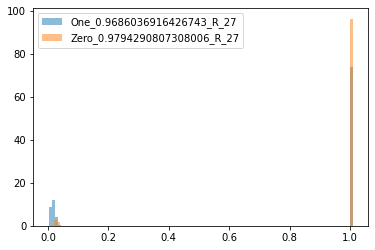

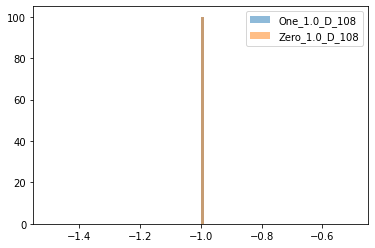

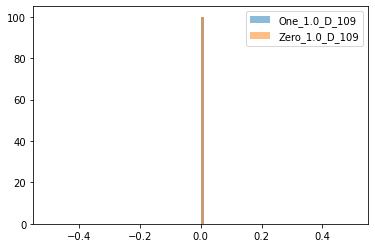

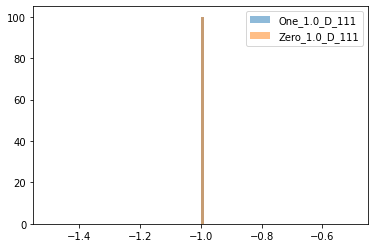

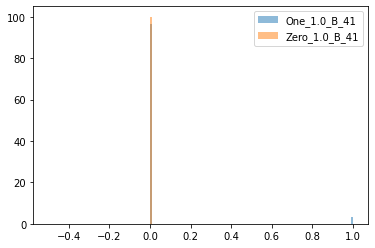

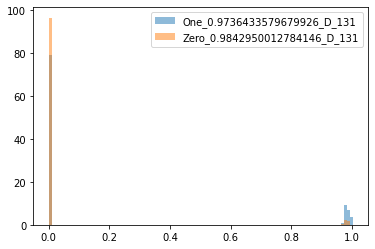

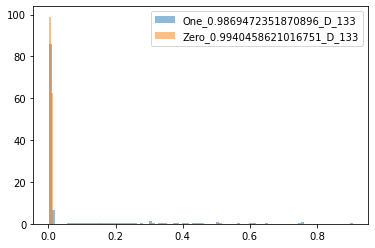

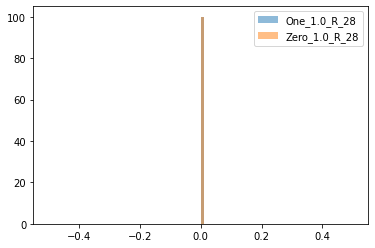

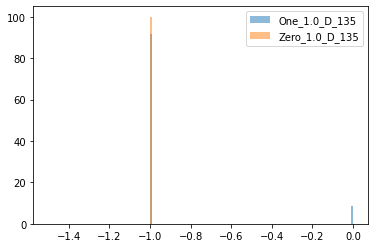

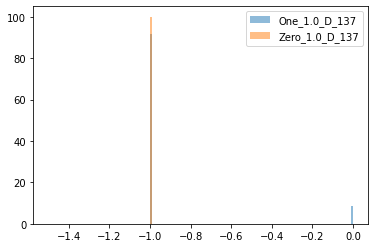

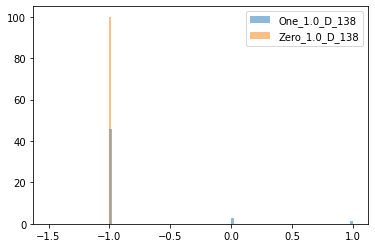

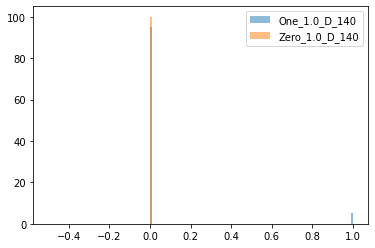

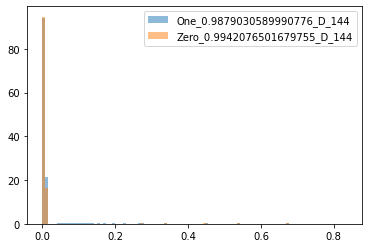

In [145]:
N0 = c0d.shape[0]
N1 = c1d.shape[0]

feat_dist = {}

for c in prob_mass_dense_cols.keys():
    feat_dist[c] = {}
    if  train_data.dtypes[c] != object:
        d1 = c1d[c].dropna()
        q11 = d1.quantile(.02)
        q12 = d1.quantile(.98)
        hist1 = plt.hist(d1, range=[q11, q12], bins=100, label=f"One_{d1.shape[0]/N1}_{c}", density=True, alpha=0.5)
        feat_dist[c][1] = hist1
        d0 = c0d[c].dropna()
        q01 = d0.quantile(.02)
        q02 = d0.quantile(.98)
        hist0 = plt.hist(d0, range=[q01, q02], bins=100, label=f"Zero_{d0.shape[0]/N0}_{c}", density=True, alpha=0.5)
        feat_dist[c][0] = hist0
        feat_dist[c]["q2"] = np.minimum(q01, q11)
        feat_dist[c]["q98"] = np.maximum(q02, q12)
        plt.legend()
        plt.show()

## Get the Empirical distribution of the data

In [ ]:
feat_dist = {}

for c in train_data.columns:
    feat_dist[c] = {}
    if  train_data.dtypes[c] != object:
        
        d1 = c1d[c].dropna()
        q11 = d1.quantile(.02)
        q12 = d1.quantile(.98)
        
        d0 = c0d[c].dropna()
        q01 = d0.quantile(.02)
        q02 = d0.quantile(.98)
        
        cdf1 = ECDF(d1)
        cdf0 = ECDF(d0)
        
        feat_dist[c][1] = cdf1
        feat_dist[c][0] = cdf0
        feat_dist[c]["q2"] = np.maximum(q01, q11)
        feat_dist[c]["q98"] = np.maximum(q02, q12)
        

Count the number of unique values of each columns for each cutomer. Seems like some of the columns for the label ZERO are the same and they change slightly for customers with label one. 

If we are gonna look into this step by step, I can: 
    - do not count in the 13 if q99-q1 == 0
    - Eliminate all the columns with density of greater than 95?


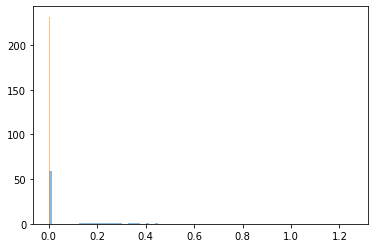

In [129]:

c = "B_36"
c = "D_41"
feat_dist[c] = {}
d1 = c1d[c].dropna()
q11 = d1.quantile(.02)
q12 = d1.quantile(.98)
hist1 = plt.hist(d1, range=[q11, q12], bins=100, label=f"One_{d1.shape[0]/N1}_{c}", density=True, alpha=0.5)
feat_dist[c][1] = hist1
d0 = c0d[c].dropna()
q01 = d0.quantile(.02)
q02 = d0.quantile(.98)
hist0 = plt.hist(d0, range=[q01, q02], bins=100, label=f"Zero_{d0.shape[0]/N0}_{c}", density=True, alpha=0.5)
feat_dist[c][0] = hist0
feat_dist[c]["q2"] = np.minimum(q01, q11)
feat_dist[c]["q98"] = np.maximum(q02, q12)


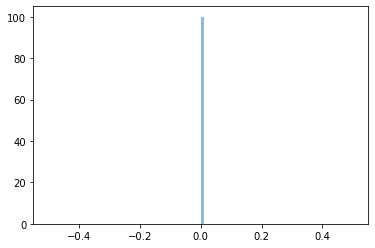

In [87]:
a = plt.hist(train_data[c], range=[train_data[c].quantile(0.01), train_data[c].quantile(0.99)], bins=100, density=True, alpha=0.5)

In [125]:
col_info = {}
prob_mass_dense_cols = {}

for c in ContCols:
    col_info[c] = {}
    d = train_data[c]
    q2 = d.quantile(0.02)
    q98 = d.quantile(0.98)
    col_min_val = d.min()
    col_max_val = d.max()
    hist = np.histogram(d, range=[q2, q98], density=True, bins=100)
    
    col_info[c]["q2"] = q2
    col_info[c]["q98"] = q98
    col_info[c]["min"] = col_min_val
    col_info[c]["max"] = col_max_val
    col_info[c]["hist"] = hist
    col_info[c]["max_prob_mass"] = hist[0].max()
    
    if col_info[c]["max_prob_mass"] > 90:
        prob_mass_dense_cols[c] = col_info[c]["max_prob_mass"]

In [99]:
d = train_data[c]
q1 = d.quantile(0.01)
q99 = d.quantile(0.99)
np.histogram(d, range=[q1, q99], density=True, bins=100)[0].max()

99.99999999999991

In [126]:
prob_mass_dense_cols.keys().__len__()

63

In [133]:
np.count_nonzero(col_info["R_12"]["hist"][0])

64

In [142]:
import pickle
with open(OUTDIR+"col_info.pkl", "wb") as f:
    pickle.dump(col_info, f)


In [143]:
col_info[c]["q2"]

0.0